# Area of Interest Definition and Product Downloads

This notebook defines three forest fires in northern Germany in 2018 and 2019 for based on newspaper coverage during the fire and information published later by governmental bodies.

After introducing relevant articles, it uses the OpenStreetMap API to query products before and after the fire and thereby builds the foundation for further analysis.

## Setup

In [1]:
from datetime import date, timedelta
import os
from pathlib import Path
from sentinel_helpers import search_osm, plot_downloaded_products, geodataframe_on_map
from sentinelsat import SentinelAPI
from tqdm.notebook import tqdm

api = SentinelAPI(os.getenv('SCIHUB_USERNAME'), os.getenv('SCIHUB_PASSWORD'))

out_dir = Path('resources/forest_fires')
out_dir.mkdir(exist_ok=True, parents=True)

## Treuenbrietzen 2018

_Deutsche Welle_, a German public broadcaster, [published an article](https://web.archive.org/web/20210222122952/https://www.dw.com/en/forest-fires-near-berlin-could-burn-for-days/a-45203042) covering fires "some 50 kilometers outside the German capital" on August 24 2018. The article was published while the fires were burning and noted that they "began on Thursday" (August 23 2018). It contains a map designating the position of three towns and villages which had to be evacuated and takes note that train traffic was disturbed as a direct consequence of the ongoing fire.

### Area of Interest Definition

Using information from the article, the evacuated places positions can be queried from OpenStreetMap:

In [2]:
import geopandas as gpd
import pandas as pd

frohnsdorf = search_osm('Frohnsdorf, Brandenburg').head(n=1)
klausdorf = search_osm('Klausdorf, Brandenburg').head(n=1)
tiefenbrunnen = search_osm('Tiefenbrunnen, Brandenburg').head(n=1)

evacuated_places = gpd.GeoDataFrame(pd.concat([frohnsdorf, klausdorf, tiefenbrunnen]))
geodataframe_on_map(evacuated_places)

Comparing these search results with the map given in the article, they appear to be correct.
They are saved for later use.

In [3]:
evacuated_places.to_file(out_dir / 'treuenbrietzen_2018.json', driver='GeoJSON')

### Product Subselection

To calculate the dNBR, the NBR has to be calculated before and after the actual fire.
It estimates damaged plan material, so it is best calculated before processes such as regrowth and plant activity have taken place. Similarly, the pre-fire NBR should be as close to the start of the fire as possible.

Because the exact location of the fire is not mentioned in the article, a bounding box containing the three evacuated places is constructed and a geometric buffer around it calculated. These buffer calculations take place in EPSG:25833, which is a metric coordinate reference system, as opposed to EPSG:4326, which uses angular units.

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:xlabel='beginposition'>

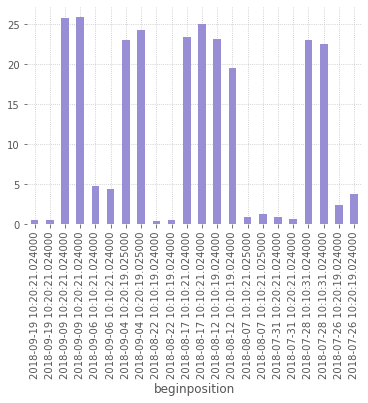

In [4]:
from shapely.geometry import box

# construct footprint using bounding box containing all 3 points
footprint_2018 = box(*evacuated_places.to_crs('epsg:25833').buffer(2500).to_crs('epsg:4326').unary_union.bounds)

# query the api using information from the article and bounding box
fire_date = date(2018, 8, 23)
pre_fire_treuenbrietzen = fire_date - timedelta(weeks=4)
post_fire_treuenbrietzen = fire_date + timedelta(weeks=4)
results = api.query(footprint_2018.wkt,
                    platformname='Sentinel-2',
                    processinglevel='Level-2A',
                    date=(pre_fire_treuenbrietzen, post_fire_treuenbrietzen),
                    cloudcoverpercentage=(0, 30))

# plot cloud coverage to discard unusable products
gdf = SentinelAPI.to_geodataframe(results)
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

There are a set of products with very low cloud coverage immediately before the outbreak of the fire on August 22, another set of product with low cloud coverage on September 9 and a third set another ten days later with close to no cloud coverage is available.

The results are deduplicated to avoid reprojecting an merging. For this purpose the position of the evacuated places in the downloaded product's tile geometry is plotted:

<AxesSubplot:title={'center':'Area of Interest and Available Products'}>

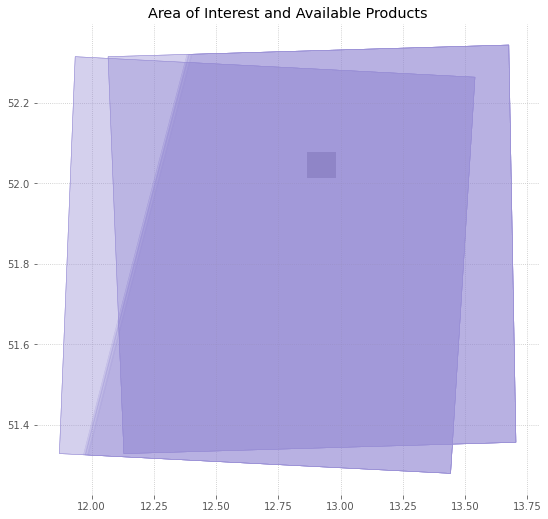

In [5]:
plot_downloaded_products(gdf, footprint_2018, figsize=(9,9))

All available tiles contain the area of interest.
The tile UTM tile numbers of the results are T33UUT and T32UQC.

In [6]:
gdf['tile'] = gdf['title'].apply(lambda t: t.split('_')[5])
gdf['tile'].unique()

array(['T33UUT', 'T32UQC'], dtype=object)

All products not covering T33UUT are discarded.

<AxesSubplot:xlabel='beginposition'>

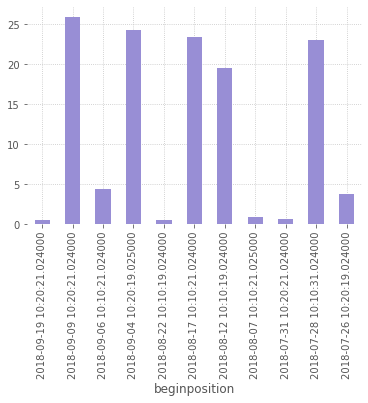

In [7]:
gdf = gdf[gdf['tile'] == 'T33UUT']
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

The products at August 22, September 6 and, because the exact duration of the fire is unknown, the September 19 are selected for download.

In [8]:
timestamps = [
    '2018-08-22 10:10:19.024000',
    '2018-09-06 10:10:21.024000',
    '2018-09-19 10:20:21.024000',
]
product_uuids_treuenbrietzen = gdf[gdf['beginposition'].isin(timestamps)]['uuid'].values

out_dir.mkdir(exist_ok=True, parents=True)
downloaded, initialized, failed = api.download_all(product_uuids_treuenbrietzen, out_dir)

In [9]:
len(downloaded), len(initialized), len(failed)

(3, 0, 0)

The files were downloaded to the following paths, which can be copied into [](02e-spectral-indices.ipynb) to calculate their NBR.

In [10]:
list(out_dir.glob('*2018*T33UUT*.zip'))

[PosixPath('resources/forest_fires/S2A_MSIL2A_20180906T101021_N0208_R022_T33UUT_20180906T131549.zip'),
 PosixPath('resources/forest_fires/S2A_MSIL2A_20180919T102021_N0208_R065_T33UUT_20180919T132226.zip'),
 PosixPath('resources/forest_fires/S2B_MSIL2A_20180822T101019_N0208_R022_T33UUT_20180822T161243.zip')]

## Jueterbog 2019

On June 10 2019, _rbb24_, another German public broadcaster, [published an article](https://web.archive.org/web/20190622070809/https://www.rbb24.de/panorama/beitrag/2019/06/waldbrand-jueterbog-sonntag-lage-unter-kontrolle.html) noting that "one of the largest fires of the past decades" was successfully extinguished. The fire fighters were active for a week, starting on Monday, June 3. The fire was burning close to the former military site in Jüterbog, Brandenburg.

### Area of Interest Definition

In [11]:
jueterbog = search_osm('Jüterbog, Brandenburg')
jueterbog = jueterbog[(jueterbog['type'] == 'administrative') & (jueterbog['osm_type'] == 'relation')]
jueterbog

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry
0,257891092,relation,422436,"Jüterbog, Teltow-Fläming, Brandenburg, 14913, ...",16,boundary,administrative,0.685236,https://nominatim.openstreetmap.org/ui/mapicon...,"POLYGON ((12.95605 52.03939, 12.96134 52.03944..."


In [12]:
geodataframe_on_map(jueterbog)

In [13]:
jueterbog.to_file(out_dir / 'jueterbog_2019.json', driver='GeoJSON')

### Product Subselection

Similarly to the fire in Treuenbrietzen in 2018, the area of interest is buffered to increase the likelihood of obtaining products that contain data on the fire.

In [14]:
buffered = jueterbog.to_crs('epsg:25833').buffer(2500).to_crs('epsg:4326')
geodataframe_on_map(buffered)

The buffered geometry is used to search for available products, which are then selected by proximity to the fire date and cloud coverage:

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:xlabel='beginposition'>

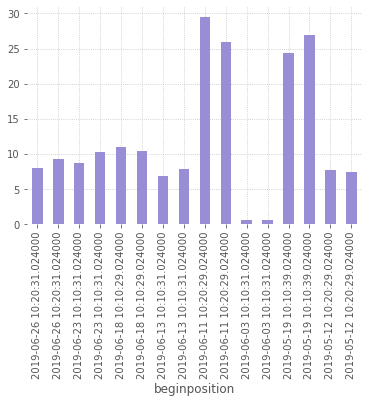

In [15]:
# define time range
fire_date = date(2019, 6, 3)
pre_fire_jueterbog = fire_date - timedelta(weeks=4)
post_fire_jueterbog = fire_date + timedelta(weeks=4)

# query api
footprint_jueterbog = buffered.iloc[0].convex_hull
results = api.query(footprint_jueterbog.wkt,
                    platformname='Sentinel-2',
                    processinglevel='Level-2A',
                    date=(pre_fire_jueterbog, post_fire_jueterbog),
                    cloudcoverpercentage=(0, 30))

# plot cloud coverage over time
gdf = SentinelAPI.to_geodataframe(results)
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

- how well do the results cover our study area?

<AxesSubplot:title={'center':'Area of Interest and Available Products'}>

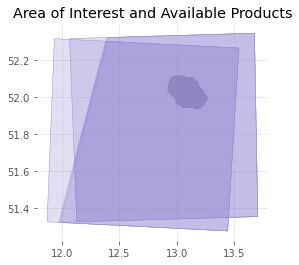

In [16]:
plot_downloaded_products(gdf, buffered)

- again, well!

<AxesSubplot:xlabel='beginposition'>

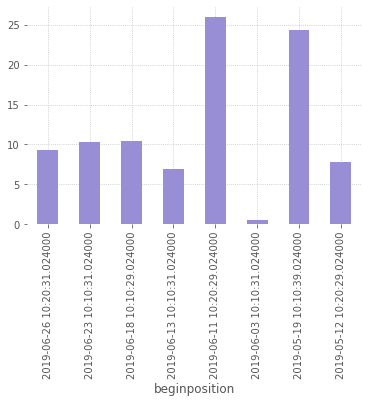

In [17]:
gdf['tile'] = gdf['title'].apply(lambda t: t.split('_')[5])
gdf = gdf[gdf['tile'] == 'T33UUT']
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

In [18]:
timestamps = [
    '2019-06-03 10:10:31.024000', # closely before the fire?
    '2019-06-13 10:10:31.024000', # after the fire, low clouds
    '2019-06-26 10:20:31.024000', # another post-fire product within cloud coverage < 30%,
]
product_uuids_jueterbog = gdf[gdf['beginposition'].isin(timestamps)]['uuid'].values
downloaded, initialized, failed = api.download_all(product_uuids_jueterbog, out_dir)

In [19]:
len(downloaded), len(initialized), len(failed)

(3, 0, 0)

The downloaded products can be found at the following paths, which, like previously, can be used to calculate the NBR in the product NBR using [](02-spectral-indices.ipynb).

In [20]:
list(out_dir.glob('*2019*T33UUT*.zip'))

[PosixPath('resources/forest_fires/S2A_MSIL2A_20190613T101031_N0212_R022_T33UUT_20190614T125329.zip'),
 PosixPath('resources/forest_fires/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUT_20190603T114652.zip'),
 PosixPath('resources/forest_fires/S2A_MSIL2A_20190626T102031_N0212_R065_T33UUT_20190626T125319.zip')]

## Lübtheen 2019

The wildfire in Lübtheen 2019 is interesting because it was burning during a Sentinel-2 flyover, which ESA took as an opportunity to [publish an animation](https://web.archive.org/web/20210223154159/https://earth.esa.int/eogateway/news/german-wildfire) that shows the actively burning fire both as a true-color image and as a faux-color composite that highlights the burn scar using short-wave infrared measurements. The article the animation was published in mentions that the fire started on June 30 2019. The flyover happened on July 1.

The animation provides an unusually clear depiction of the active fire area: There is no such information in the other two articles. This information can therefore be related to own NBR calculations and information published by official sources in follow-up reports.

### Area of Interest Definition

In [21]:
luebtheen = search_osm('Lübtheen, Germany')
luebtheen = luebtheen[(luebtheen['osm_type'] == 'relation') & (luebtheen['type'] == 'administrative')]
luebtheen

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry
0,258938877,relation,1451563,"Lübtheen, Ludwigslust-Parchim, Mecklenburg-Vor...",16,boundary,administrative,0.573723,https://nominatim.openstreetmap.org/ui/mapicon...,"POLYGON ((10.98272 53.32736, 10.98394 53.32676..."


In [22]:
geodataframe_on_map(luebtheen)

In [23]:
luebtheen.to_file(out_dir / 'luebtheen_2019.json', driver='GeoJSON')

### Product Subselection

Using information from the article, the Copernicus Open Access Hub is queried for available products and, which are then selected for download depending on their cloud coverage and proximity to the fire dates.

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:xlabel='beginposition'>

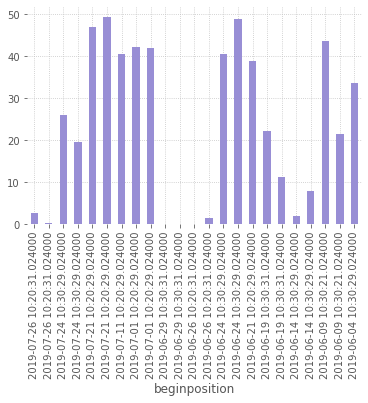

In [24]:
luebtheen_date = date(2019, 6, 30)
luebtheen_before = luebtheen_date - timedelta(weeks=4)
luebtheen_after = luebtheen_date + timedelta(weeks=4)
luebtheen_footprint = luebtheen['geometry'].iloc[0].convex_hull

results = api.query(luebtheen_footprint.wkt,
                    platformname='Sentinel-2',
                    processinglevel='Level-2A',
                    date=(luebtheen_before, luebtheen_after),
                    cloudcoverpercentage=(0, 50))
gdf = SentinelAPI.to_geodataframe(results)
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

<AxesSubplot:title={'center':'Area of Interest and Available Products'}>

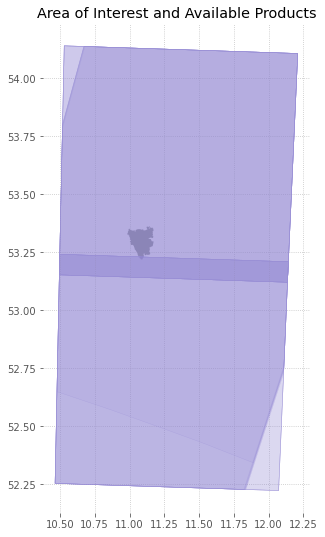

In [25]:
plot_downloaded_products(gdf, luebtheen, figsize=(9,9))

Lübtheen sits close to the edge of the applied tiling grid. Tiles which do not cover Lübtheen entirely are discarded.

In [26]:
gdf['tile'] = gdf['title'].apply(lambda t: t.split('_')[5])
gdf['tile'].unique()

array(['T32UPD', 'T32UPE'], dtype=object)

<AxesSubplot:title={'center':'Area of Interest and Available Products'}>

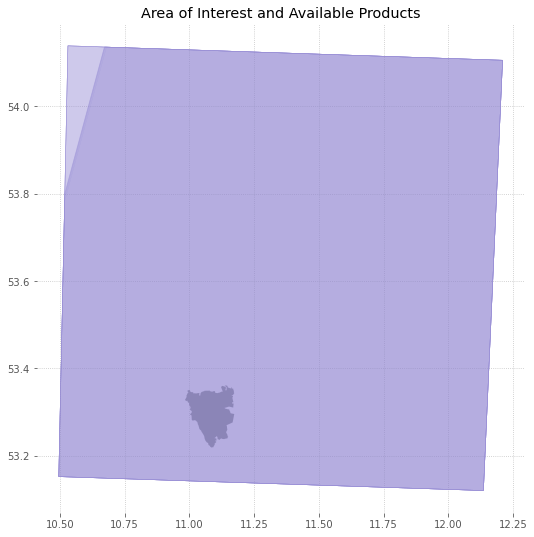

In [27]:
plot_downloaded_products(gdf[gdf['tile'] == 'T32UPE'], luebtheen, figsize=(9,9))

<AxesSubplot:xlabel='beginposition'>

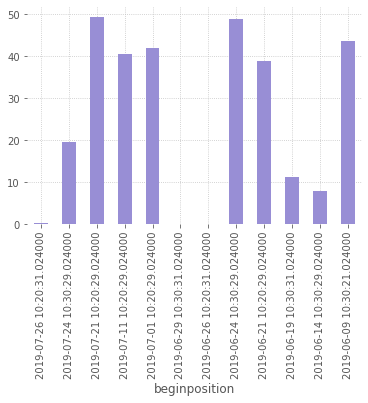

In [28]:
gdf = gdf[gdf['tile'] == 'T32UPE']
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

The cloud cover plot above shows that immediately before the start of the fire a very clear product was captured. The product at July 1 2019 is also selected to be able to compare it with the animation published by ESA. Another product several weeks later, on July 26, provides the next clear view on the area.

In [29]:
timestamps = [
    '2019-06-29 10:30:31.024000', # before the fire, almost no clouds
    '2019-07-01 10:20:29.024000', # during the fire; the esa picture is generated from this
    '2019-07-26 10:20:31.024000', # after the fire, within cloud coverage < 50%
]
product_uuids_luebtheen_2019 = gdf[gdf['beginposition'].isin(timestamps)]['uuid'].values

In [30]:
downloaded, initialized, failed = api.download_all(product_uuids_luebtheen_2019, out_dir)
len(downloaded), len(initialized), len(failed)

(3, 0, 0)

The list of downloaded products to be used for NBR calculation is as follows:

In [31]:
list(out_dir.glob('*2019*T32UPE*.zip'))

[PosixPath('resources/forest_fires/S2B_MSIL2A_20190701T102029_N0212_R065_T32UPE_20190701T134657.zip'),
 PosixPath('resources/forest_fires/S2A_MSIL2A_20190726T102031_N0213_R065_T32UPE_20190726T125507.zip'),
 PosixPath('resources/forest_fires/S2A_MSIL2A_20190629T103031_N0212_R108_T32UPE_20190629T135351.zip')]